## Dependences for the project


In [234]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import joblib
from sklearn.preprocessing import StandardScaler

### loading the dataset

In [235]:
# Load dataset
def load_images(directory):
    images, labels = [], []
    for label, category in enumerate(['first_print', 'second_print']):
        path = os.path.join(directory, category)
        if not os.path.exists(path):
            print(f"Warning: {path} does not exist!")
            continue
        for filename in os.listdir(path):
            img_path = os.path.join(path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (128, 128))
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

In [236]:
# Set dataset path
dataset_path = "D:/dataset"  # Change this to your actual dataset path
X, y = load_images(dataset_path)
X = X / 255.0  # Normalize pixel values
X = X.reshape(X.shape[0], 128, 128, 1)  # Reshape for CNN

Total images: 200
Original Prints: 100  | Counterfeit Prints: 100


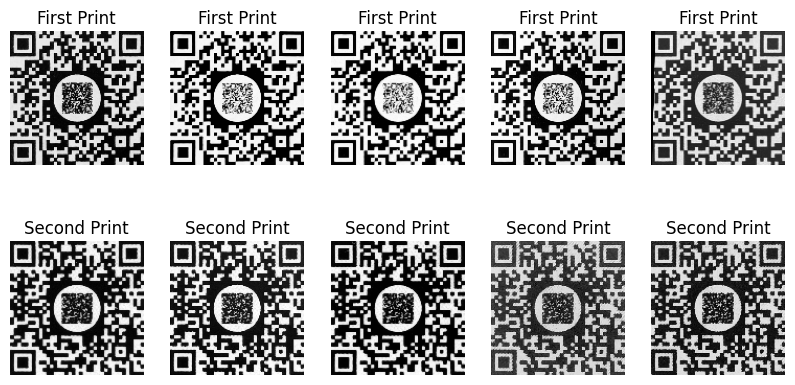

In [237]:
# Load images
X, y = load_images(dataset_path)

# Check dataset balance
print("Total images:", len(X))
print("Original Prints:", sum(y == 0), " | Counterfeit Prints:", sum(y == 1))

# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(5):
    axes[0, i].imshow(X[i], cmap="gray")
    axes[0, i].set_title("First Print" if y[i] == 0 else "Second Print")
    axes[0, i].axis("off")
    axes[1, i].imshow(X[-(i+1)], cmap="gray")
    axes[1, i].set_title("First Print" if y[-(i+1)] == 0 else "Second Print")
    axes[1, i].axis("off")
plt.show()



- **Total Images:** 200
- **First Prints:** 100 | - **Second Prints:** 100
- **Mean Pixel Intensity:** 113.21
- **Standard Deviation (Contrast):** 98.75


In [238]:
# Compute basic statistics
means = [np.mean(img) for img in X]
std_devs = [np.std(img) for img in X]
print(means)
print(std_devs)

[np.float64(98.6678466796875), np.float64(129.0096435546875), np.float64(130.128662109375), np.float64(129.3980712890625), np.float64(102.50799560546875), np.float64(132.05511474609375), np.float64(100.750244140625), np.float64(132.37860107421875), np.float64(132.64263916015625), np.float64(122.8548583984375), np.float64(133.64056396484375), np.float64(101.093505859375), np.float64(133.95379638671875), np.float64(131.9820556640625), np.float64(106.03387451171875), np.float64(113.03009033203125), np.float64(136.71649169921875), np.float64(99.32733154296875), np.float64(131.58392333984375), np.float64(131.96343994140625), np.float64(110.5328369140625), np.float64(134.87677001953125), np.float64(104.4652099609375), np.float64(133.31463623046875), np.float64(133.92010498046875), np.float64(101.87725830078125), np.float64(135.32061767578125), np.float64(106.36090087890625), np.float64(129.1953125), np.float64(132.257568359375), np.float64(110.1763916015625), np.float64(134.56085205078125), 

### Feature Engineering 

**Compute Image Statistics**

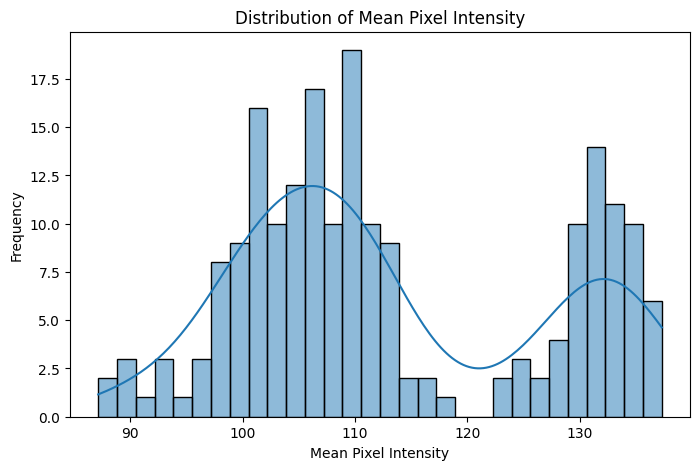

In [239]:
# Visualize Mean Pixel Intensity Distribution
plt.figure(figsize=(8, 5))
sns.histplot(means, bins=30, kde=True)
plt.xlabel("Mean Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Distribution of Mean Pixel Intensity")
plt.show()


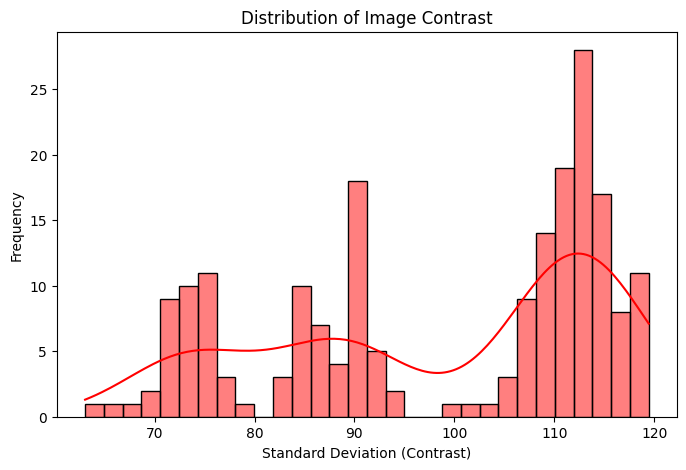

In [240]:
# Visualize Standard Deviation (Contrast) Distribution
plt.figure(figsize=(8, 5))
sns.histplot(std_devs, bins=30, kde=True, color="red")
plt.xlabel("Standard Deviation (Contrast)")
plt.ylabel("Frequency")
plt.title("Distribution of Image Contrast")
plt.show()

**Check Feature Differences Using Edge Detection**

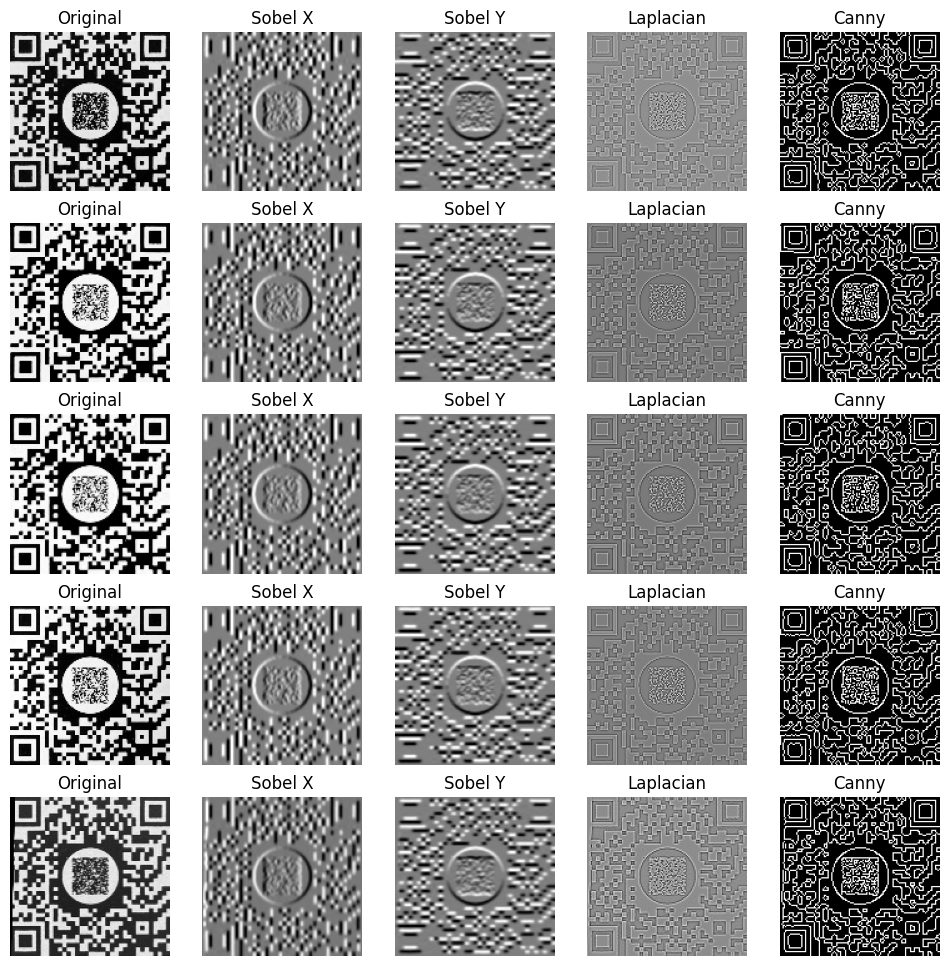

In [241]:
def apply_edge_detection(image):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)  # Sobel X
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)  # Sobel Y
    laplacian = cv2.Laplacian(image, cv2.CV_64F)  # Laplacian
    canny = cv2.Canny(image, 50, 150)  # Canny Edge Detection
    return sobelx, sobely, laplacian, canny

# Display Edge Detection Results for Sample Images
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
sample_images = [X[i] for i in range(5)]  # Take 5 sample images
titles = ["Original", "Sobel X", "Sobel Y", "Laplacian", "Canny"]

for i, img in enumerate(sample_images):
    sobelx, sobely, laplacian, canny = apply_edge_detection(img)
    edge_images = [img, sobelx, sobely, laplacian, canny]

    for j in range(5):
        axes[i, j].imshow(edge_images[j], cmap="gray")
        axes[i, j].set_title(titles[j])
        axes[i, j].axis("off")

plt.show()




1. **Sobel X (`sobelx`)**:
    - The Sobel operator is used for edge detection by calculating the gradient of the image intensity in the horizontal direction (X-axis). 
    - It highlights vertical edges in the image.

2. **Sobel Y (`sobely`)**:
    - Similar to Sobel X, but calculates the gradient in the vertical direction (Y-axis).
    - It highlights horizontal edges in the image.

3. **Laplacian (`laplacian`)**:
    - The Laplacian operator computes the second derivative of the image intensity, which detects edges regardless of their orientation.
    - It is more sensitive to noise compared to Sobel operators.

4. **Canny (`canny`)**:
    - The Canny edge detector is a multi-step algorithm that detects edges by applying Gaussian smoothing, gradient calculation, non-maximum suppression, and thresholding.
    - It is widely used for robust edge detection.

**Feature Extraction (Histogram of Oriented Gradients - HOG)**

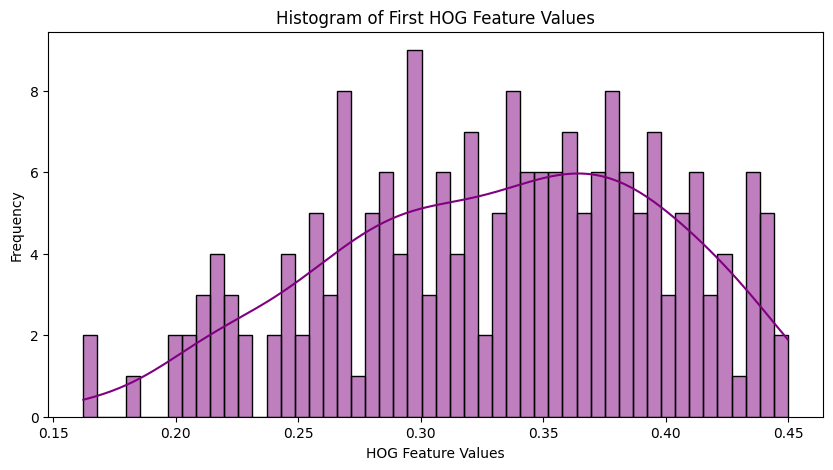

In [242]:
from skimage.feature import hog

# Extract HOG features
hog_features = []
for img in X:
    features, _ = hog(img, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=True)
    hog_features.append(features)

hog_features = np.array(hog_features)

# Visualize Histogram of HOG Features
plt.figure(figsize=(10, 5))
sns.histplot(hog_features[:, 0], bins=50, kde=True, color="purple")
plt.xlabel("HOG Feature Values")
plt.ylabel("Frequency")
plt.title("Histogram of First HOG Feature Values")
plt.show()


**Local Binary Patterns (LBP)**

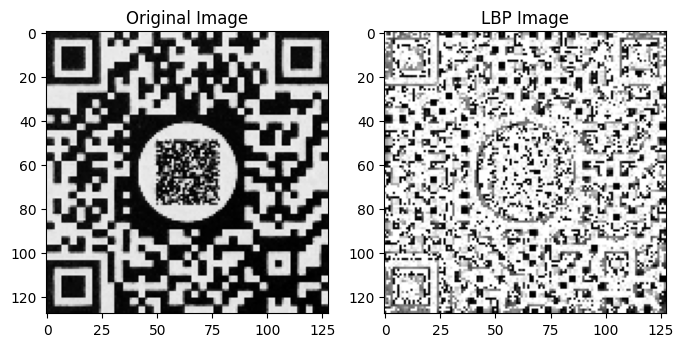

In [243]:
from skimage.feature import local_binary_pattern

# Define parameters for LBP
n_points = 24  # Number of circularly symmetric neighbor set points
radius = 3     # Radius of circle

# Use a sample image from the dataset
image = X[0].squeeze()  # Assuming X contains grayscale images

# Compute LBP
lbp = local_binary_pattern(image, n_points, radius, method='uniform')

# Display results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("LBP Image")
plt.imshow(lbp, cmap='gray')

plt.show()

Gabor filter

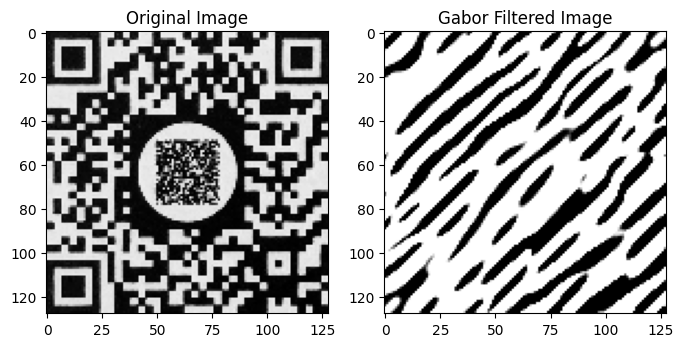

In [244]:
# Define Gabor filter parameters
ksize = 31  # Kernel size
sigma = 4.0  # Standard deviation
theta = np.pi / 4  # Orientation
lambd = 10.0  # Wavelength
gamma = 0.5  # Aspect ratio

# Create Gabor kernel
gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, 0, ktype=cv2.CV_32F)

# Apply Gabor filter
filtered_img = cv2.filter2D(image, cv2.CV_8UC3, gabor_kernel)

# Display images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Gabor Filtered Image")
plt.imshow(filtered_img, cmap='gray')

plt.show()

Wavelet Transform (Haar Wavelet)

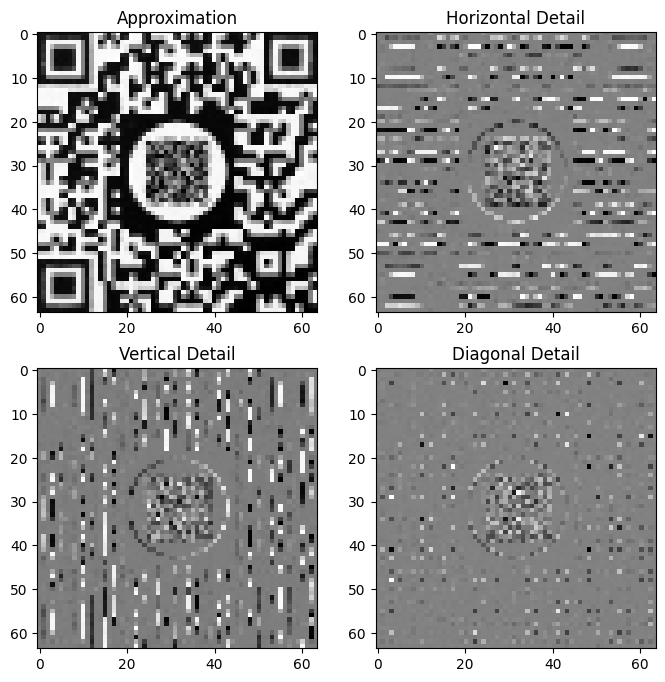

In [245]:

import pywt

coeffs2 = pywt.dwt2(image, 'haar')
cA, (cH, cV, cD) = coeffs2  # Approximation, Horizontal, Vertical, Diagonal components

# Display results
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.title("Approximation")
plt.imshow(cA, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("Horizontal Detail")
plt.imshow(cH, cmap='gray')

plt.subplot(2, 2, 3)
plt.title("Vertical Detail")
plt.imshow(cV, cmap='gray')

plt.subplot(2, 2, 4)
plt.title("Diagonal Detail")
plt.imshow(cD, cmap='gray')

plt.show()

**2. Edge and Contour-Based Features**

Canny Edge Detection

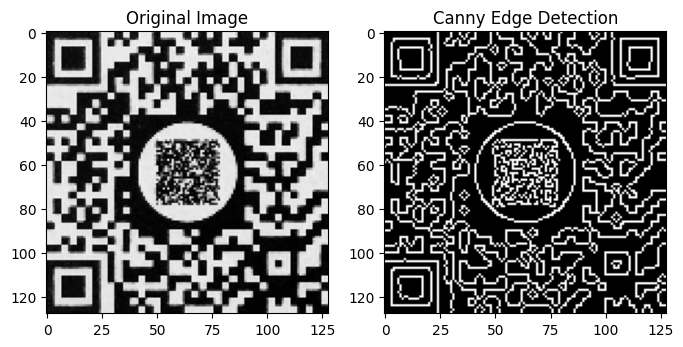

In [246]:
# Apply Canny edge detector
edges = cv2.Canny(image, 100, 200)

# Display images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Canny Edge Detection")
plt.imshow(edges, cmap='gray')

plt.show()


SIFT (Scale-Invariant Feature Transform)

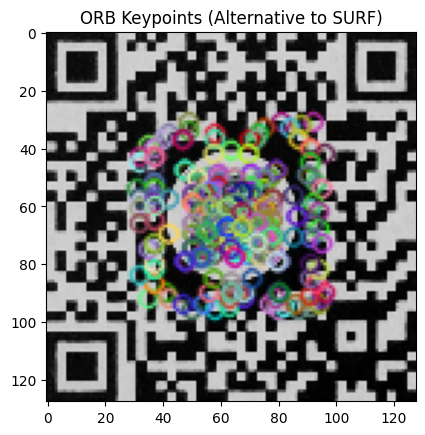

In [247]:
# Initialize ORB detector
orb = cv2.ORB_create()

# Detect keypoints and descriptors
keypoints, descriptors = orb.detectAndCompute(image, None)

# Draw keypoints on the image
orb_image = cv2.drawKeypoints(image, keypoints, None)

# Display image
plt.imshow(orb_image)
plt.title("ORB Keypoints (Alternative to SURF)")
plt.show()

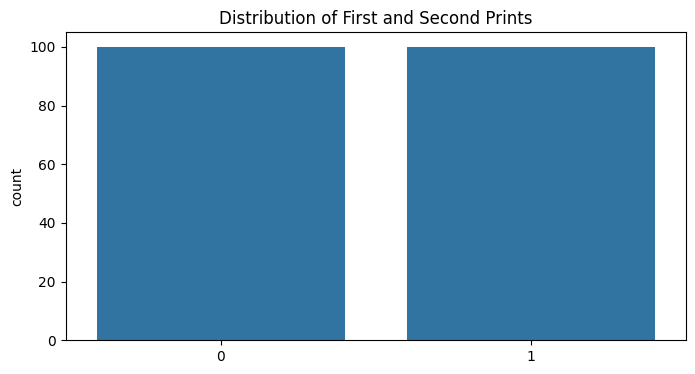

In [248]:
# Data visualization
plt.figure(figsize=(8, 4))
sns.countplot(x=y)
plt.title("Distribution of First and Second Prints")
plt.show()

**splitting the dataset here**

In [249]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Development 

**Random forest model is used and with accuarcy  and all**

In [250]:
# Traditional ML Approach (Random Forest)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train_flat, y_train)


RandomForestClassifier(n_estimators=300, random_state=42)

**Deep learning model is used here**

In [251]:
# Deep Learning Approach (CNN)
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),#resizing the image size into the 128X128
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

c:\Users\thara\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**going through the epochs with model and laso fitting the model**

In [252]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=155, batch_size=32, validation_split=0.2)

Epoch 1/155
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - accuracy: 0.5698 - loss: 323.9118 - val_accuracy: 0.5312 - val_loss: 178.6070
Epoch 2/155
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.5656 - loss: 154.0069 - val_accuracy: 0.4688 - val_loss: 45.7886
Epoch 3/155
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.5292 - loss: 32.5605 - val_accuracy: 0.5312 - val_loss: 15.1507
Epoch 4/155
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.6448 - loss: 8.8471 - val_accuracy: 0.5625 - val_loss: 2.7204
Epoch 5/155
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.7281 - loss: 1.2435 - val_accuracy: 0.8125 - val_loss: 0.6215
Epoch 6/155
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - accuracy: 0.8125 - loss: 0.8839 - val_accuracy: 0.8125 - val_loss: 0.5011
Epoch 7/155
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - accuracy: 0.8958 - loss: 0.3265 - val_accuracy: 0.8438 - val_loss: 0.3728
Epoch 8/155
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.9469 - loss: 0.2556 - val_accuracy: 0

### Evaluation and Results 

In [253]:
# Evaluate CNN Model
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f"CNN Model Accuracy: {accuracy * 100:.4f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9563 - loss: 0.1088 
CNN Model Accuracy: 95.0000%


In [254]:
y_pred_rf = rf_model.predict(X_test_flat)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Confusion Matrix:
 [[21  0]
 [ 0 19]]


**checking the accuracy and all for the CNN model**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step 
Confusion Matrix:
 [[19  2]
 [ 0 19]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.90      1.00      0.95        19

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



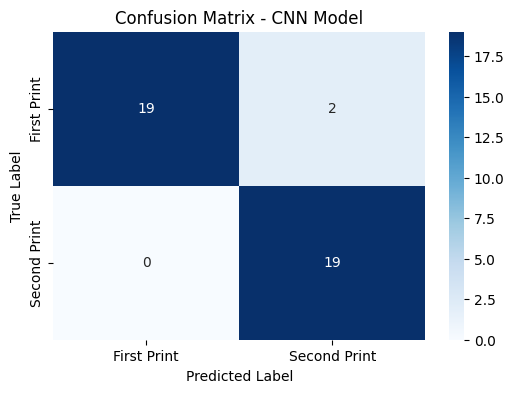

In [255]:
# Make Predictions on Test Data
y_pred_probs = cnn_model.predict(X_test)  # Get probability outputs
y_pred = (y_pred_probs > 0.5).astype("int32")  # Convert to 0 or 1 labels

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Print Confusion Matrix & Classification Report
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['First Print', 'Second Print'], yticklabels=['First Print', 'Second Print'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CNN Model")
plt.show()


Confusion Matrix - Random Forest:
 [[21  0]
 [ 0 19]]

Classification Report - Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



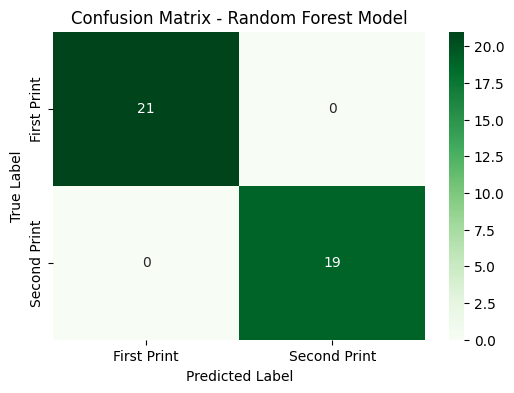

In [256]:
# Make Predictions on Test Data
y_pred_rf = rf_model.predict(X_test_flat)  # Predict using Random Forest

# Compute Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Print Confusion Matrix & Classification Report
print("Confusion Matrix - Random Forest:\n", cm_rf)
print("\nClassification Report - Random Forest:\n", classification_report(y_test, y_pred_rf))

# Plot the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['First Print', 'Second Print'], yticklabels=['First Print', 'Second Print'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest Model")
plt.show()


### Deployment Considerations 

In [257]:
# Save the trained model
save_path = r"D:\WEB\aids\EDA-Analysis\cnn_qr_model.h5"  # Change to your preferred path
cnn_model.save(save_path)
print(f"Model saved at {save_path}")

Model saved at D:\WEB\aids\EDA-Analysis\cnn_qr_model.h5


In [258]:
# Save the trained model
save_path = r"D:\WEB\aids\EDA-Analysis\random_forest_model.pkl"  # Change to your preferred path
joblib.dump(rf_model, save_path)
print(f"Model saved at {save_path}")

Model saved at D:\WEB\aids\EDA-Analysis\random_forest_model.pkl


In [259]:

# Define dataset path
dataset_path = "D:/dataset"  # Change this to your actual dataset path

# Function to load images and flatten them
def load_and_flatten_images(directory):
    images, labels = [], []
    for label, category in enumerate(['first_print', 'second_print']):
        path = os.path.join(directory, category)
        if not os.path.exists(path):
            print(f"Warning: {path} does not exist!")
            continue
        for filename in os.listdir(path):
            img_path = os.path.join(path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (128, 128))
                images.append(img.flatten())  # Flatten image for ML models
                labels.append(label)
    return np.array(images), np.array(labels)

# Load dataset and flatten images
X, y = load_and_flatten_images(dataset_path)

# Create and fit StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler
scaler_path = r"D:\WEB\aids\EDA-Analysis\scaler.pkl"  # Change this to your preferred path
joblib.dump(scaler, scaler_path)

print(f"Scaler saved at {scaler_path}")


Scaler saved at D:\WEB\aids\EDA-Analysis\scaler.pkl
